**Task 1:** Create an AI assistant that will answer "What's the temperature outside now" or "What's the temperature in Tokio now" type of questions (location can be any big city). Ask for the location of the user if the location is not in the question. Use OpenAI APIs, [openweathermap](http://api.openweathermap.org/data/2.5/weather) API(it is free), and function calling.

* Step 1: Use OpenAI Chat Completions API to get the location of the user if it is not given. If it is given, use function calling for getting weather api parameter(s).
* Step 2: Call weather api for the given location.
* Step 3: Call Chat Completions API again for processing the response of weather api. Make it to provide short answer like this: "The temperature in Yerevan is -1.91 degrees Celsius".
* Step 4: Call Chat Completions API again to translate the output of Step 3 into Armenian.
* Step 5: Use OpenAI Text to Speech API to create an audio version (mp3) of the output of Step 4.
* Step 6: Use one of OpenAIs APIs to create an image based on the output of Step 3 (text to image).
* Step 7: Use one of OpenAIs APIs to extract text (if any) from the output of Step 6
* Step 8: Create a Chainlit app that will answer the questions mentioned at the beginning of the task and will output the outputs of Steps 3, 4, 5, 6, and 7.

Useful links:
* [Chainlit App Creation](https://docs.chainlit.io/get-started/pure-python])
* [Text, Image, Audio and Video response with Chainlit](https://docs.chainlit.io/api-reference/elements/text)

**Check a Chainlit app example at the end of this notebook.**

Good luck!

In [ ]:
%%capture
#!pip install git+https://github.com/openai/whisper.git
#whisper = 20231117
#pytube = 15.0.0
#openai = 1.9.0
#requests=2.31.0
!pip install python-dotenv
!pip install whisper
!pip install openai-whisper
!pip install pytube
!pip install openai

In [ ]:
#Importing libraries
import json
import requests
import tenacity
from tenacity import retry, wait_random_exponential, stop_after_attempt
import os

import whisper
import pytube
import openai
from openai import OpenAI
from dotenv import load_dotenv

GPT_MODEL = "gpt-4-turbo-preview"

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Read the API key from environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")

# Step 1. Function Calling

# Define a function to handle calls to OpenAI

This function accepts and handles defined functions and regular messages.

In [ ]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}
    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

# We use this to tell OpenAI that there is a function that can obtain weather in a city

We provide available function. GPT itself decides what arguments to use from our prompts when calling this function. There is no need to manually extract location and other parameters. GPT should do it itself from your input texts.

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Gets the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city name only. No country or state required",
                    },
                },
                "required": ["location"],
            },
        }
    },
]

# Next, we prompt GPT. We explicitely ask it to clarifiy our location if we do not provide it.

When we do not provide a location, it will ask us for it.

In [ ]:
# Keep all our conversations here
messages = []

# System prompt. We ask it not to assume our location
messages.append({
    "role": "system",
    "content": "Don't make assumptions about what values to plug into functions. Ask for location if it is not provided"
})

# Ask it what is the temperature now
messages.append({
    "role": "user",
    "content": "What's the temperature outside now."
})

# Call the api. Note that we pass on the defined functions with tools here.
chat_response = chat_completion_request(
    messages,
    tools=tools
)

# get the response
assistant_message = chat_response.json()["choices"][0]["message"]

# Insert it into our chat history
messages.append(assistant_message)

if not assistant_message["content"]:
    loc = json.loads(assistant_message['tool_calls'][0]["function"]['arguments'])["location"]
else:
    # Note that GPT recognised that it doesn't know where we are. So, it asks us. We just need to asnwer it back by appending the answer to our history of messages.
    messages.append({
    "role": "user",
    "content": "I'm in Yerevan, Armenia."
    })

    #print(f"Now our conversation is like this\n {messages}")

    chat_response = chat_completion_request(
        messages,
        tools=tools
    )

    assistant_message = chat_response.json()["choices"][0]["message"]
    messages.append(assistant_message)
    loc = json.loads(assistant_message['tool_calls'][0]["function"]['arguments'])["location"]
print(loc)

Yerevan


# Step 2. Call the weather api

In [ ]:
def get_weather(loc):

    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": loc,
        "APPID": "3dbbcaefaee14eb4243faed7b7ccb28d"
    }

    response = requests.get(url, params=params)
    return response.text

In [ ]:
weather_api_response = get_weather(loc)

In [ ]:
weather_api_response

'{"coord":{"lon":44.5136,"lat":40.1811},"weather":[{"id":803,"main":"Clouds","description":"broken clouds","icon":"04d"}],"base":"stations","main":{"temp":279.24,"feels_like":278.29,"temp_min":279.24,"temp_max":279.24,"pressure":1005,"humidity":87},"visibility":6000,"wind":{"speed":1.54,"deg":230},"clouds":{"all":75},"dt":1710860441,"sys":{"type":1,"id":8851,"country":"AM","sunrise":1710817606,"sunset":1710861152},"timezone":14400,"id":616052,"name":"Yerevan","cod":200}'

# Step 3. Process the weather API output

In [ ]:
def extract_weather(weather_api_response):

    client = OpenAI(api_key=openai.api_key)

    response = client.chat.completions.create(
      model=GPT_MODEL,
      messages=[
        {"role": "system", "content": "You are weather API assistant.Round the temperature. Provide short answer like this: The temperature in Yereven is 5 celcius."},
        {"role": "user", "content": f"What is the temerature in celcius in the location based on this: {weather_api_response}"}
      ]
    )
    return response.choices[0].message.content

text = extract_weather(weather_api_response)

In [ ]:
text

'The temperature in Yerevan is 6 Celsius.'

# Step 4. Translate the sentence into Armenian

In [ ]:
def translate_into_am(text):

    client = OpenAI(api_key=openai.api_key)

    response = client.chat.completions.create(
      model = GPT_MODEL,
      messages = [
        {"role": "system", "content": """You are professional translator. Translate into the language instructed.
        Translate any numbers or symbols into text.
        Original: The temperature in Yerevan is 10 Celsius.
        Translation: Երևանում ջերմաստիճանը տասը աստիճան ցելսիուս է։
        Original: The temperature in Tavush is 12 Celsius.
        Translation: Տավուշում ջերմաստիճանը տասներկու աստիճան ցելսիուս է։

        """},
        {"role": "user", "content": f"Translate into Armenian this text: {text}"}
      ]
    )
    return response.choices[0].message.content

text_am = translate_into_am(text)

In [ ]:
text_am

'Երևանում ջերմաստիճանը վեց աստիճան ցելսիուս է։'

# Step 5. Text to Speech

In [ ]:
def convert_TTS(text_am):

    client = OpenAI(api_key=openai.api_key)

    text_to_speech = client.audio.speech.create(
      model="tts-1-hd",
      voice="echo",
      input=text_am
    )
    return text_to_speech.stream_to_file("weather.mp3")

convert_TTS(text_am)

<ipython-input-18-52c66cd695c3>:10: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  return text_to_speech.stream_to_file("weather.mp3")


# Step 6. Generate text from image and extract any text from generated image

In [ ]:
def gen_image_from_text(text):

    client = OpenAI(api_key=openai.api_key)

    image_gen = client.images.generate(
      model="dall-e-3",
      prompt=f"Generate realistic image based on this text:{text}. Depict temperature as a number as well.",
      size="1024x1024",
      quality="standard",
      n=1,
    )
    image_url = image_gen.data[0].url
    response = requests.get(image_url)
    return response, image_url

image, image_url = gen_image_from_text(text)

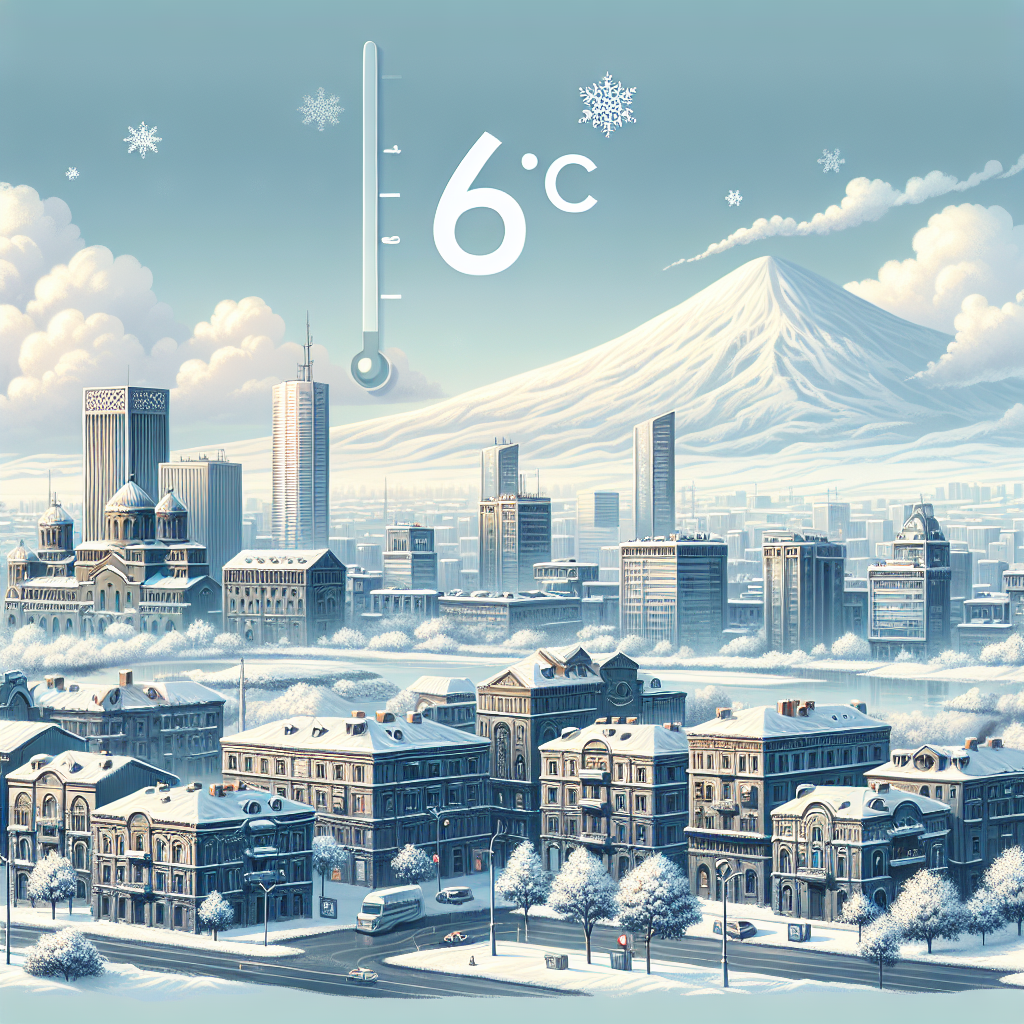

In [ ]:
from PIL import Image
from io import BytesIO
from IPython.display import display

# Save the image
with open("generated_image.jpg", 'wb') as f:
    f.write(image.content)

# Display the image
img = Image.open(BytesIO(image.content))
display(img)

# Step 7. Extract text from an image

In [ ]:
def extract_text_from_image(image_url):

    client = OpenAI(api_key=openai.api_key)
    response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
          {"role": "system", "content": "You are text extractor from image. If there is no text, output there is no text in the image."},
          {"role": "user",
            "content": [
                {
                  "type": "text",
                  "text": "Output text from the image."
                },
                {
                  "type": "image_url",
                  "image_url": {
                      "url": image_url
                  }
                }
            ]
        }
      ]
    )
    return response.choices[0].message.content

In [ ]:
extract_text_from_image(image_url)

'The text in the image reads "6°c".'

# Task 2

Use a python library to download a short video from YouTube (e.g. https://github.com/pytube/pytube ), transcribe the text of the video with OpenAIs Whisper API, and use OpenAI's Moderation API to check it. Print the transcribed text and Moderation API response.

# Download and Transcribe

In [ ]:
from pytube import YouTube
import whisper
import os

In [ ]:
video = YouTube('hhttps://www.youtube.com/watch?v=RcXzmO8zOLg').streams.first()
video.download()

'/content/Sam Altman there’s no “magic red button” to stop AI.mp4'

In [ ]:
model = whisper.load_model("base")
result_video = model.transcribe([ i for i in os.listdir() if ".mp4" in i][0])
print(result_video["text"])

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 103MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 These are two of the most important people shaping the future of artificial intelligence. Sam Altman, the CEO of OpenAI, the startup behind chat GPT, and Satya Nadella, the CEO of Microsoft, OpenAI's biggest investor. They spoke to the economist, editor-in-chief, about what the future of AI really looks like. Sam, let's start with you. What are the most important capabilities that chat GPT will develop in the next year? The world had like a two week freak out with GPT-4, right? This changes everything. AGI's coming tomorrow. There are no jobs by the end of the year. And now people are like, why is it so slow? Um... And I love that. I think that's a great thing about the human spirit that we always want more and better. We've not had this where there has been some general public technology whose diffusion happened instantaneously everywhere. In any place, healthcare and education is most of the government's spend. You now have, right, the ability to give every student and every citizen

# Call the moderations API

In [ ]:
import requests

url = "https://api.openai.com/v1/moderations"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + openai.api_key
}
data = {
    "input": f"{result_video['text']}"
}

response = requests.post(url, headers=headers, json=data)

response.json()

{'id': 'modr-94VmrSNjYbtzalYuJY0EH2agXjsmV',
 'model': 'text-moderation-007',
 'results': [{'flagged': False,
   'categories': {'sexual': False,
    'hate': False,
    'harassment': False,
    'self-harm': False,
    'sexual/minors': False,
    'hate/threatening': False,
    'violence/graphic': False,
    'self-harm/intent': False,
    'self-harm/instructions': False,
    'harassment/threatening': False,
    'violence': False},
   'category_scores': {'sexual': 3.44123545801267e-05,
    'hate': 0.00028190421289764345,
    'harassment': 0.00020562257850542665,
    'self-harm': 2.4674116616552055e-07,
    'sexual/minors': 1.7787493789001019e-06,
    'hate/threatening': 8.869603334460407e-06,
    'violence/graphic': 0.00015017525583971292,
    'self-harm/intent': 9.711968118608638e-08,
    'self-harm/instructions': 1.585449496133151e-07,
    'harassment/threatening': 3.066585122724064e-05,
    'violence': 0.0003205970278941095}}]}